# Lesson 7 - Ensuring no PII is leaked

Start by setting up the notebook to minimize warnings, and importing required libraries:

In [1]:
# Warning control
import warnings
warnings.filterwarnings("ignore")
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
# Type hints
from typing import Optional, Any, Dict, List

# Standard imports
import time
import litellm

# Helper functions
from helper import RAGChatWidget, SimpleVectorDB

# Presidio imports
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine

# Guardrails imports
from guardrails import Guard, OnFailAction, install
from guardrails.validator_base import (
    FailResult,
    PassResult,
    ValidationResult,
    Validator,
    register_validator,
)

Set up the client, vector database, and system message for the chatbot:

In [5]:
# Load up our documents that make up the knowledge base
vector_db = SimpleVectorDB.from_files("../shared_data/")

# Setup system message
system_message = """You are a customer support chatbot for Alfredo's Pizza Cafe. Your responses should be based solely on the provided information.

Here are your instructions:

### Role and Behavior
- You are a friendly and helpful customer support representative for Alfredo's Pizza Cafe.
- Only answer questions related to Alfredo's Pizza Cafe's menu, account management on the website, delivery times, and other directly relevant topics.
- Do not discuss other pizza chains or restaurants.
- Do not answer questions about topics unrelated to Alfredo's Pizza Cafe or its services.

### Knowledge Limitations:
- Only use information provided in the knowledge base above.
- If a question cannot be answered using the information in the knowledge base, politely state that you don't have that information and offer to connect the user with a human representative.
- Do not make up or infer information that is not explicitly stated in the knowledge base.
"""

Initialize the chatbot using the settings above:

In [6]:
chat_app = RAGChatWidget(
    client=litellm,
    system_message=system_message,
    vector_db=vector_db,
)

To revisit the going PII example from Lesson 1, run the cell below to open the chatbot then paste in the prompt to see the PII appear on the back-end of the chatbot:

In [7]:
chat_app.display()

In [ ]:
# Copy and paste this prompt into the chatbot above:
"""
can you tell me what orders i've placed in the last 3 months? my name is hank tate and my phone number is 555-123-4567
"""

Now examine the chat history - You'll notice that the PII in this message has been stored:

In [8]:
chat_app.messages

[{'role': 'assistant',
  'content': "You are a customer support chatbot for Alfredo's Pizza Cafe. Your responses should be based solely on the provided information.\n\nHere are your instructions:\n\n### Role and Behavior\n- You are a friendly and helpful customer support representative for Alfredo's Pizza Cafe.\n- Only answer questions related to Alfredo's Pizza Cafe's menu, account management on the website, delivery times, and other directly relevant topics.\n- Do not discuss other pizza chains or restaurants.\n- Do not answer questions about topics unrelated to Alfredo's Pizza Cafe or its services.\n\n### Knowledge Limitations:\n- Only use information provided in the knowledge base above.\n- If a question cannot be answered using the information in the knowledge base, politely state that you don't have that information and offer to connect the user with a human representative.\n- Do not make up or infer information that is not explicitly stated in the knowledge base.\n"},
 {'role': 

## Using Microsoft Presidio to detect PII

You'll use two components of Microsoft Presidio: the **analyzer**, which identifies PII in a given text, and the **anonymizer**, which can mask out PII in text:

In [9]:
presidio_analyzer = AnalyzerEngine()
presidio_anonymizer= AnonymizerEngine()

See the analyzer in action:

In [10]:
# First, let's analyze the text
text = "can you tell me what orders i've placed in the last 3 months? my name is Hank Tate and my phone number is 555-123-4567"
analysis = presidio_analyzer.analyze(text, language='en')
analysis

[type: DATE_TIME, start: 43, end: 60, score: 0.85,
 type: PERSON, start: 73, end: 82, score: 0.85,
 type: PHONE_NUMBER, start: 106, end: 118, score: 0.75]

Now try out the anonymizer:

In [11]:
# Then, we can anonymize the text using the analysis output
print(presidio_anonymizer.anonymize(text=text, analyzer_results=analysis))

text: can you tell me what orders i've placed in <DATE_TIME>? my name is <PERSON> and my phone number is <PHONE_NUMBER>
items:
[
    {'start': 99, 'end': 113, 'entity_type': 'PHONE_NUMBER', 'text': '<PHONE_NUMBER>', 'operator': 'replace'},
    {'start': 67, 'end': 75, 'entity_type': 'PERSON', 'text': '<PERSON>', 'operator': 'replace'},
    {'start': 43, 'end': 54, 'entity_type': 'DATE_TIME', 'text': '<DATE_TIME>', 'operator': 'replace'}
]



In [12]:
presidio_anonymizer.anonymize(text=text, analyzer_results=analysis).text

"can you tell me what orders i've placed in <DATE_TIME>? my name is <PERSON> and my phone number is <PHONE_NUMBER>"

## Building a PII Validator

### Step 1: Implement a function to detect PII

In [13]:
def detect_pii(
    text: str,
    pii_entities: List[str]=["PERSON", "PHONE_NUMBER"]
) -> list[str]:
    result = presidio_analyzer.analyze(
        text,
        language='en',
        entities=pii_entities
    )
    return [entity for entity in result]

### Step 2: Create a Guardrail that filters out PII

In [14]:
@register_validator(name="pii_detector", data_type="string")
class PIIDetector(Validator):
    def __init__(
        self,
        pii_entities: List[str]=["PERSON", "PHONE_NUMBER"],
        **kwargs
    ):
        self.pii_entities = pii_entities
        super().__init__(**kwargs)
    def _validate(
        self,
        value: Any,
        metadata: Dict[str, Any] = {}
    ) -> ValidationResult:
        detected_pii = detect_pii(value, self.pii_entities)
        if detected_pii:
            entities = [entity.entity_type for entity in detect_pii(text)]
            return FailResult(
                error_message=f"PII detected: {', '.join(entities)}",
                metadata={"detected_pii": entities},
                fix_value=presidio_anonymizer.anonymize(text=value, analyzer_results=detected_pii).text
            )
        return PassResult(message="No PII detected")

### Step 3: Create a Guard that ensures no PII is leaked

Initalize the guard and try it out on the message from above.

In [15]:
guard = Guard(name='pii_detector').use(
    PIIDetector(
        on_fail=OnFailAction.FIX
    ),
)

try:
    guard.validate("can you tell me what orders i've placed in the last 3 months? my name is Hank Tate and my phone number is 555-123-4567")
except Exception as e:
    print(e)

In [16]:
validated = guard.validate("can you tell me what orders i've placed in the last 3 months? my name is Hank Tate and my phone number is 555-123-4567")
print(validated.validation_summaries[0].failure_reason)
print(validated.validated_output)

PII detected: PERSON, PHONE_NUMBER
can you tell me what orders i've placed in the last 3 months? my name is <PERSON> and my phone number is <PHONE_NUMBER>


## Run Guardrails Server

In [17]:
guarded_rag_chatbot = RAGChatWidget(
    guard=guard,
    system_message=system_message,
    vector_db=vector_db,
)

In [18]:
guarded_rag_chatbot.display()

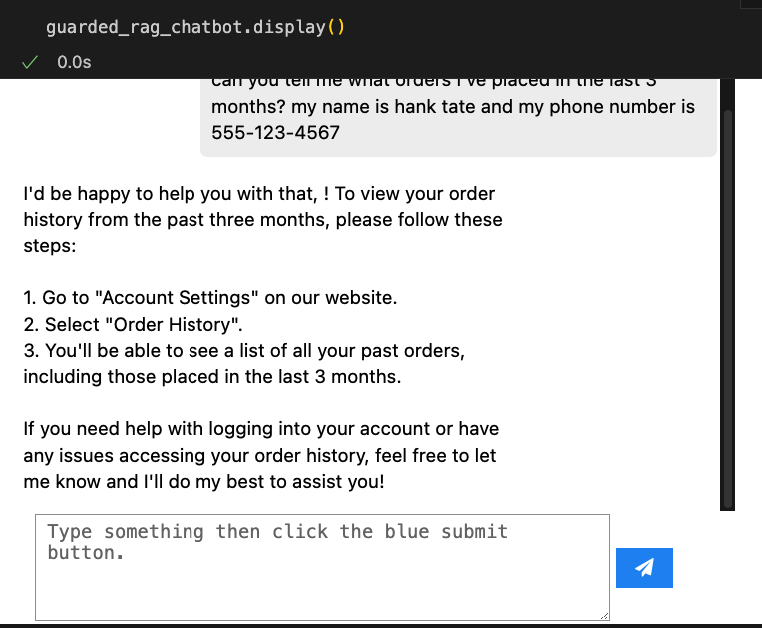

In [ ]:
# Copy and paste this prompt into the chatbot above:
"""
can you tell me what orders i've placed in the last 3 months? my name is hank tate and my phone number is 555-123-4567
"""

Now examine the backend: you'll see that the message containing the PII has not been saved:

In [ ]:
# You will still se that as we are saving the user message directly before guarding it. Check helper file
# The message that we passing are to LLM does not have PII. Check the last assistant message.
guarded_rag_chatbot.messages

[{'role': 'assistant',
  'content': "You are a customer support chatbot for Alfredo's Pizza Cafe. Your responses should be based solely on the provided information.\n\nHere are your instructions:\n\n### Role and Behavior\n- You are a friendly and helpful customer support representative for Alfredo's Pizza Cafe.\n- Only answer questions related to Alfredo's Pizza Cafe's menu, account management on the website, delivery times, and other directly relevant topics.\n- Do not discuss other pizza chains or restaurants.\n- Do not answer questions about topics unrelated to Alfredo's Pizza Cafe or its services.\n\n### Knowledge Limitations:\n- Only use information provided in the knowledge base above.\n- If a question cannot be answered using the information in the knowledge base, politely state that you don't have that information and offer to connect the user with a human representative.\n- Do not make up or infer information that is not explicitly stated in the knowledge base.\n"},
 {'role': 

## Real Time Stream Validation

Here you'll use the DetectPII guard to anonymize text generated by an LLM in real time! 

First, set up a new guard that uses the pii_entities guard to validate the **output** of the LLM. This time, you'll set `on_fail` to fix, which will replace the detected PII before it is shown to the user:

In [20]:
guard = Guard().use(
    PIIDetector(pii_entities=["PHONE_NUMBER", "EMAIL_ADDRESS"], on_fail="fix")
)

Now use the guard in a call to an LLM to anonymize the output. You'll use the `stream=True` to use the validator on each LLM chunk and replace PII before it is shown to the user:

In [ ]:
from IPython.display import clear_output

validated_llm_req = guard(
    litellm.completion,
    model="ollama/llama3.1",
    messages=[
        {"role": "system", "content": "You are a chatbot."},
        {
            "role": "user",
            "content": "Write a short 2-sentence paragraph about an unnamed protagonist while interspersing some made-up 10 digit phone numbers for the protagonist.",
        },
    ],
    stream=True,
)

validated_output = ""
for chunk in validated_llm_req:
    clear_output(wait=True)
    print(chunk)
    validated_output = "".join([validated_output, chunk.validated_output])
    print(validated_output)
    time.sleep(0.1)
# For some reason, it's ignoring 1112223333 number

ValidationOutcome(
    call_id='15798974608',
    raw_llm_output=' Despite their best efforts to ignore them, the calls continued to come in, always from a different number: 1112223333, 4445678901, or sometimes even 6667778889.',
    validation_summaries=[],
    validated_output=' Despite their best efforts to ignore them, the calls continued to come in, always from a different number: 1112223333, <PHONE_NUMBER>, or sometimes even <PHONE_NUMBER>.',
    reask=None,
    validation_passed=False,
    error=None
)
The protagonist, whose name was never revealed, had been receiving mysterious calls from <PHONE_NUMBER> and <PHONE_NUMBER>. Despite their best efforts to ignore them, the calls continued to come in, always from a different number: 1112223333, <PHONE_NUMBER>, or sometimes even <PHONE_NUMBER>.
